In [182]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/train.csv


In [183]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

In [184]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('cuda')
else:
    device = torch.device('cpu')
    print('cpu')

cuda


In [185]:
df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv').sample(frac=1)
print(df.columns)
print(len(df))

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)
42000


In [186]:
Y = df[['label']].values
X = df.drop(['label'], axis=1).values

In [187]:
X = X.reshape([-1, 28, 28])
X = X/255.0
Y = [np.eye(10)[i] for i in Y]

In [188]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 256, 3)
        self.flatten_size = None
        x = torch.randn(28,28).view(-1,1,28,28)
        x = self.conv(x)
        self.fc1 = nn.Linear(self.flatten_size, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, 10)
        
    def conv(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, (2,2))
        if self.flatten_size is None:
            self.flatten_size = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x
    
    
    def forward(self, x):
        x = self.conv(x).view(-1,self.flatten_size)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x
    

model = Net().to(device)
optimizer = optim.Adam(model.parameters())
loss_function = nn.BCEWithLogitsLoss()
EPOCHS = 8
batch_size = 128
validate_perc = 0.2
validate_count = int(validate_perc * X.shape[0])

In [189]:
X = torch.Tensor(X)
Y = torch.Tensor(Y)
X_train = X[:-validate_count]
Y_train = Y[:-validate_count]
X_val = X[-validate_count:]
Y_val = Y[-validate_count:]

In [190]:
def train(X, Y, model, loss_function, optimizer, batch_size, EPOCHS):
    losses = []
    for epoch in range(EPOCHS):
        epoch_losses = []
        for batch in tqdm(range(0, X.shape[0], batch_size)):
            x_batch = X[batch:batch+batch_size].view(-1, 1, 28, 28).to(device)
            y_batch = Y[batch:batch+batch_size].view(-1, Y.shape[2]).to(device)
            model.zero_grad()
            optimizer.zero_grad()
            y_hat = model.forward(x_batch)
            loss = loss_function(y_hat, y_batch)
            loss.backward()
            optimizer.step()
            if batch % 5*batch_size:
                losses.append(loss)
                epoch_losses.append(loss)
        print(np.min(epoch_losses))
    return model, losses    

In [191]:
def validate(model, x, y):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(x))):
            real_class = torch.argmax(y[i].to(device))
            net_out = model(x[i].view(-1, 1, 28, 28).to(device))
            predicted_class = torch.argmax(net_out)

            if predicted_class == real_class:
                correct += 1
            total += 1
    print(correct/total)

In [192]:
def predict(model, x):
    y = []
    with torch.no_grad():
        for i in tqdm(range(len(x))):
            y_hat = torch.argmax(model(x[i].view(-1, 1, 28, 28).to(device)))
            y.append(int(y_hat))
        return Y

In [193]:
model, losses = train(X_train, Y_train, model, loss_function, optimizer, batch_size, EPOCHS)

 10%|▉         | 26/263 [00:00<00:00, 252.94it/s]

tensor(0.6590, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 10%|▉         | 26/263 [00:00<00:00, 255.50it/s]

tensor(0.6561, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 10%|▉         | 26/263 [00:00<00:00, 252.00it/s]

tensor(0.6552, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 10%|▉         | 26/263 [00:00<00:00, 250.87it/s]

tensor(0.6552, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 10%|▉         | 26/263 [00:00<00:00, 250.70it/s]

tensor(0.6552, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  6%|▌         | 16/263 [00:00<00:01, 152.99it/s]

tensor(0.6552, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 10%|▉         | 26/263 [00:00<00:00, 253.77it/s]

tensor(0.6552, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


100%|██████████| 263/263 [00:01<00:00, 215.72it/s]

tensor(0.6552, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


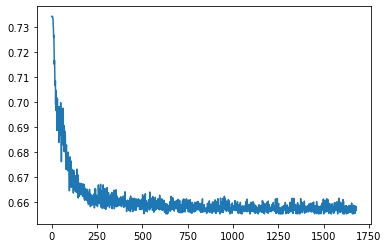

In [194]:
plt.plot(losses)

In [195]:
validate(model, X_train[:X_val.shape[0]], Y_train[:X_val.shape[0]])
validate(model, X_val, Y_val)

  1%|▏         | 121/8400 [00:00<00:06, 1209.06it/s]

0.9838095238095238


100%|██████████| 8400/8400 [00:07<00:00, 1169.75it/s]

0.9763095238095238


In [ ]:
torch.save(model, 'model.h5')